In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from keras.datasets import mnist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Convert the dataset to NumPy array and normalize the data
X_train = X_train.reshape((-1, 1, 28, 28)).astype(np.float32) / 255.
X_test = X_test.reshape((-1, 1, 28, 28)).astype(np.float32) / 255.
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [5]:
# Convert the datasets to PyTorch tensors
x_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

x_train.shape, y_train.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [6]:
# Create TensorDatasets and DataLoaders
batch_size = 64
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

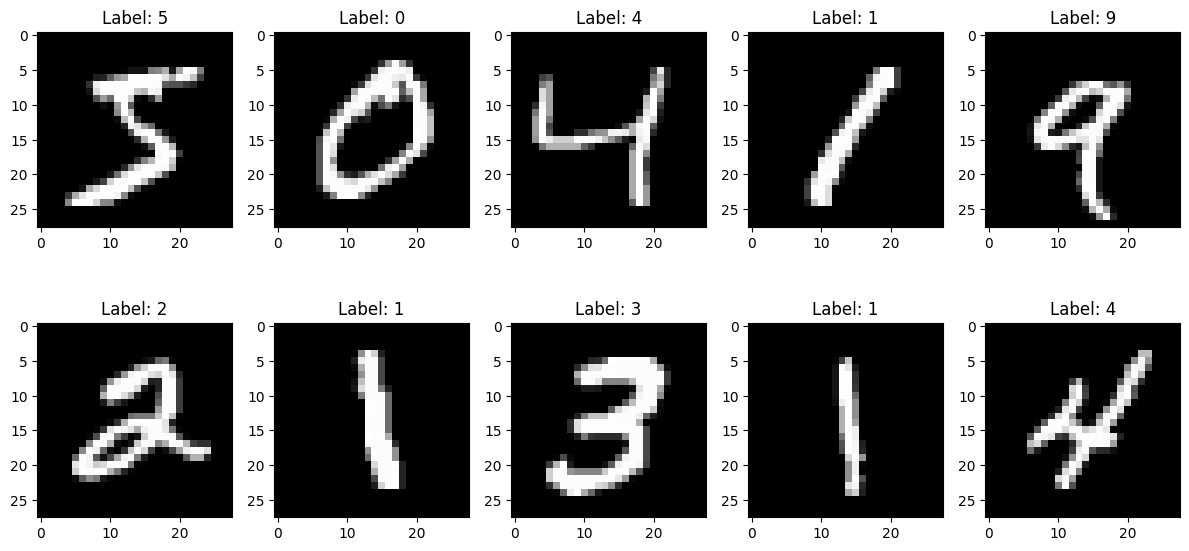

In [7]:
# Visualize sample images from the training set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < 10:
        img = X_train[i].squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {y_train[i]}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Calculate and visualize mean images per class
mean_images = []
for digit in range(10):
    mean_image = np.mean(X_train[y_train == digit], axis=0)
    mean_images.append(mean_image)

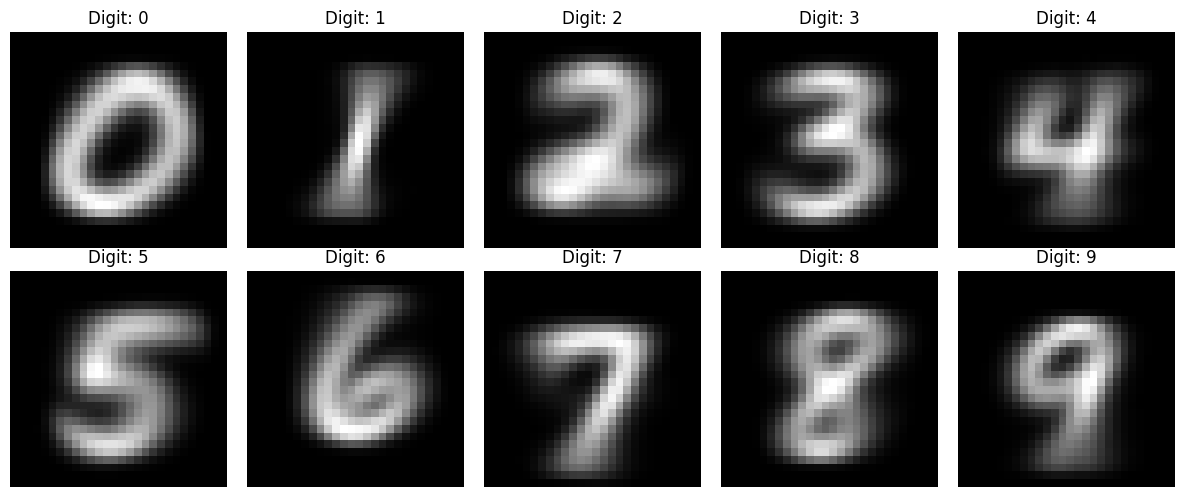

In [9]:
# Plot mean images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, (ax, mean_image) in enumerate(zip(axes, mean_images)):
    ax.imshow(mean_image.reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-10-5ad8e350dd96>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[y_train == digit].reshape(-1, 784).ravel(), ax=ax, kde=False)


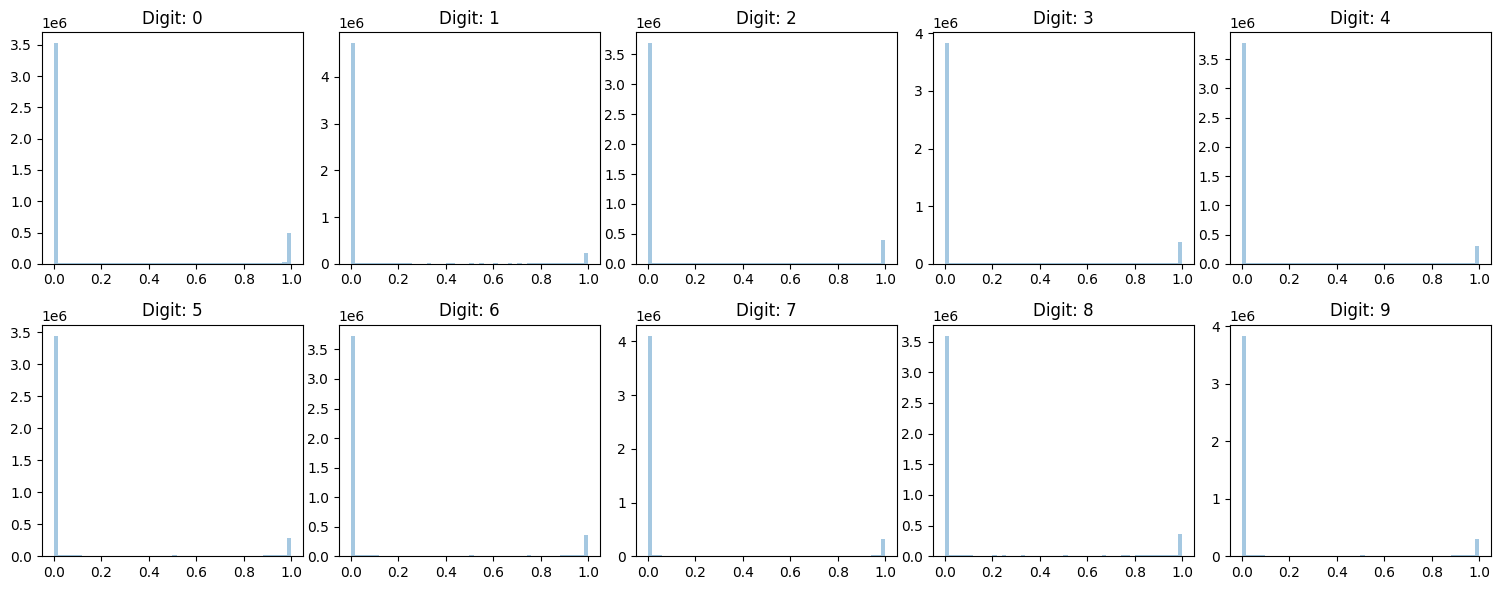

In [10]:
# Analyze pixel intensity distributions per class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, digit in enumerate(range(10)):
    ax = axes[i]
    sns.distplot(X_train[y_train == digit].reshape(-1, 784).ravel(), ax=ax, kde=False)
    ax.set_title(f'Digit: {digit}')

plt.tight_layout()
plt.show()

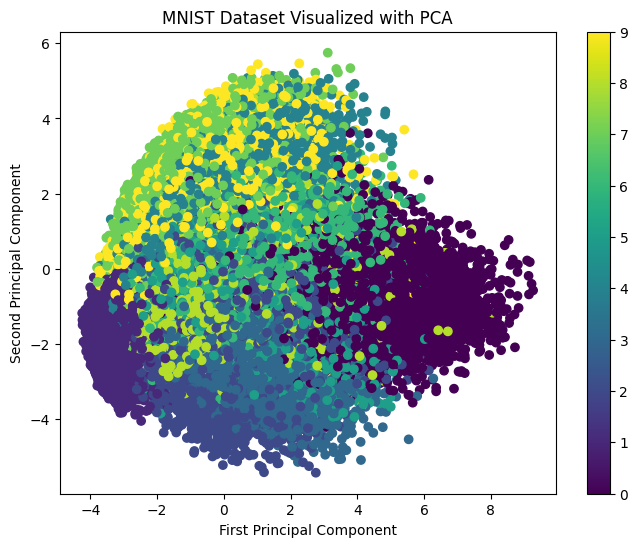

In [11]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.reshape(-1, 784))

# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('MNIST Dataset Visualized with PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

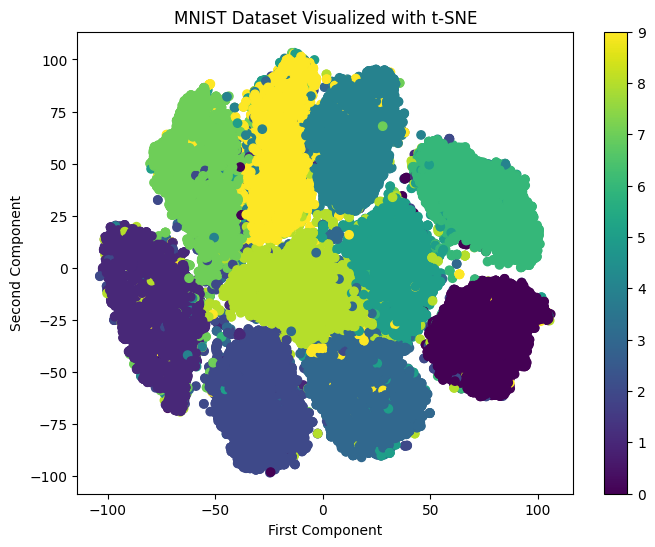

In [12]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train.reshape(-1, 784))

# Visualize t-SNE components
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('MNIST Dataset Visualized with t-SNE')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.show()

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# Instantiate the model
model = CNN().to(device)

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [16]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.488
[1,   400] loss: 0.127
[1,   600] loss: 0.096
[1,   800] loss: 0.079
[2,   200] loss: 0.053
[2,   400] loss: 0.057
[2,   600] loss: 0.051
[2,   800] loss: 0.047
[3,   200] loss: 0.034
[3,   400] loss: 0.036
[3,   600] loss: 0.037
[3,   800] loss: 0.038
[4,   200] loss: 0.022
[4,   400] loss: 0.026
[4,   600] loss: 0.026
[4,   800] loss: 0.027
[5,   200] loss: 0.020
[5,   400] loss: 0.023
[5,   600] loss: 0.021
[5,   800] loss: 0.019
[6,   200] loss: 0.012
[6,   400] loss: 0.013
[6,   600] loss: 0.017
[6,   800] loss: 0.021
[7,   200] loss: 0.010
[7,   400] loss: 0.011
[7,   600] loss: 0.011
[7,   800] loss: 0.014
[8,   200] loss: 0.011
[8,   400] loss: 0.008
[8,   600] loss: 0.011
[8,   800] loss: 0.015
[9,   200] loss: 0.006
[9,   400] loss: 0.006
[9,   600] loss: 0.012
[9,   800] loss: 0.009
[10,   200] loss: 0.006
[10,   400] loss: 0.008
[10,   600] loss: 0.005
[10,   800] loss: 0.011
Finished Training


In [17]:
# Accuracy
correct = 0
total = 0
y_true = []
y_pred = []

In [18]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [19]:
if total != 0:
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
else:
    print('No data to compute accuracy.')

Accuracy on test set: 99.33%


In [20]:
# Precision, Recall, F1-Score
print('Classification Report:')
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



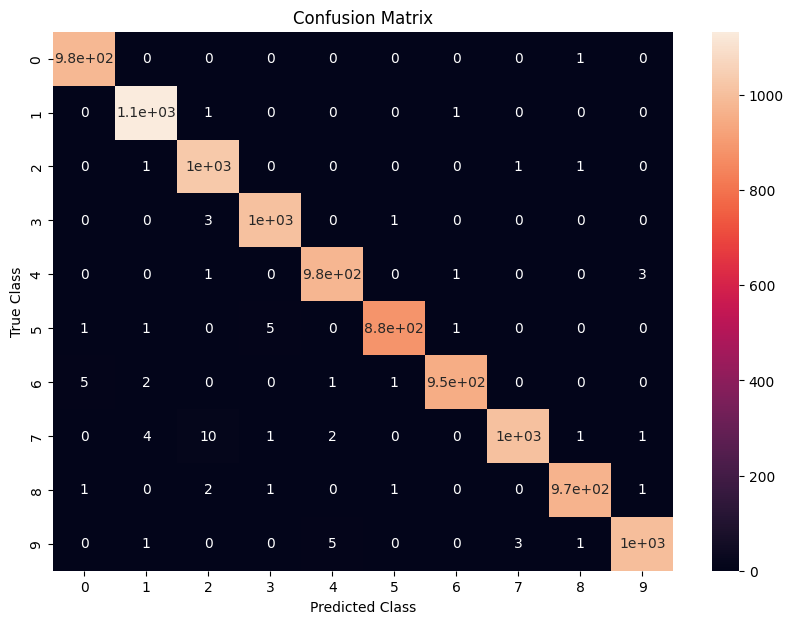

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()